In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

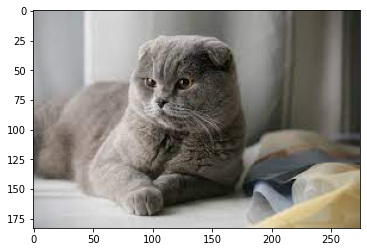

In [2]:
img = Image.open('./cat.jpg')
fig = plt.figure()
plt.imshow(img)


In [3]:
transfrom = Compose([Resize((224,224)), ToTensor()]) #this is the pipline for resizing to imagenet size 
x= transfrom(img)
x.shape
x = x.unsqueeze(0) # unsqueeze is used for to add dimention lilke when i want to concatinate x=(2,3) and y=(2,) so I will
# add y.unsqueeze(0) to make y = (2,0)
x.shape


torch.Size([1, 3, 224, 224])

To handle 2D images, we reshape images x ∈ R^ H*W*C into sequence of flattened 2D patches xp ∈ R^N*(p^2.C), where (H,W) is the resolution of the original image, C is the numbers of channals, (P,P) is the resolution of each images patch, and N=HW  /p^2 is the resulting number of patches.

In [4]:
# This code uses PyTorch and rearranges a tensor x into a new tensor pathes with a patch size of 16 pixels.
# Here's an explanation of each line:
patch_size = 16 # 16 pixels

# This line sets the patch size to 16 pixels. The patch_size variable will be 
# used later in the code to specify the size of the patches.


pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

This line rearranges the tensor x into a new tensor pathes with a patch size of 16 pixels. Here's a breakdown of what's happening:

rearrange() is a function from the einops library that can be used to rearrange the dimensions of a tensor.
x is the tensor that we want to rearrange.
'b c (h s1) (w s2) -> b (h w) (s1 s2 c)' is a string that specifies how the dimensions of the tensor should be rearranged. Here's what each part of the string means:
b: batch dimension (number of samples in a batch)
c: channel dimension (number of channels in the image)
(h s1): height dimension with a stride of s1 pixels between each patch
(w s2): width dimension with a stride of s2 pixels between each patch
->: separates the input dimensions from the output dimensions
b: batch dimension (unchanged from input)
(h w): new height dimension that combines the original height and width dimensions into a single dimension
(s1 s2 c): new width dimension that combines the original patch dimensions into a single dimension and keeps the channel dimension unchanged.
s1=patch_size, s2=patch_size are optional arguments that set the stride of the height and width dimensions to the patch size (i.e., 16 pixels).
So, in summary, this line of code rearranges the dimensions of x so that it has a new shape of (batch_size, num_patches, patch_size * patch_size * num_channels). Each element in the num_patches dimension is a flattened patch of the original image with a size of 16x16 pixels and num_channels channels.




In [5]:
class PatchEmbedding(nn.Module):# Inheriting the class nn.module
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

In [6]:
# Note After checking out the original implementation, I found out that 
# the authors are using a Conv2d layer instead of a Linear one for performance
# gain. This is obtained by using a kernel_size and stride equal to the `patch_size`. 
# Intuitively, the convolution operation is applied to each patch individually. So, we have to first 
# apply the conv layer and then flat the resulting images.

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

cls_token is a torch Parameter randomly initialized, in the forward the method it is copied b (batch) times and prepended before the projected patches using torch.cat

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size)) #Cls is token is added here
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.proj(x)
#         (b, n, e), where b is the number of batches, n is the number of patches in the image,
#         and e is the size of the token embedding. This tensor can be concatenated with the 
#         patch embeddings tensor to form the input to the transformer-based vision model.
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b) # we are changing the dim of cls so we can concate with x
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size)) #The position embedding is
#         just a tensor of shape N_PATCHES + 1 (token),EMBED_SIZE that is added to the projected patches.

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions #We added the position embedding in the .positions field and sum it to the patches 
        #in the .forward function
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

Now we need the implement Transformer. In ViT only the Encoder is used, the architecture is visualized in the following picture.

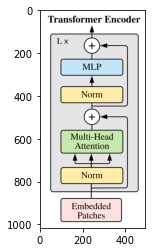

In [12]:
img1 = Image.open("./TransfromerEncoder.png")
TransfromerImage = plt.figure()
plt.imshow(img1)


# Attention
So, the attention takes three inputs, the famous queries, keys, and values, and computes the attention matrix using queries and values and use it to “attend” to the values. In this case, we are using multi-head attention meaning that the computation is split across n heads with smaller input size.

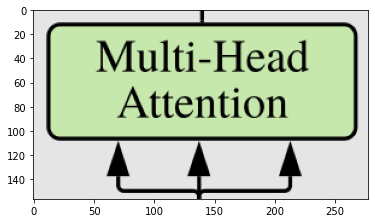

In [14]:
img1 = Image.open("./head.png")
TransfromerImage = plt.figure()
plt.imshow(img1)


This line of code is rearranging a 3-dimensional tensor of shape (batch_size, sequence_length, hidden_size) into a 4-dimensional tensor of shape (batch_size, num_heads, sequence_length, head_size). The specific function being used to rearrange the tensor is rearrange from the einops package.

Here is a breakdown of the code:

self.queries(x) is a method that applies a linear transformation to the input tensor x, resulting in a new tensor of shape (batch_size, sequence_length, num_heads * head_size). This tensor represents the queries used in the self-attention mechanism of a transformer model.

"b n (h d) -> b h n d" is a string that specifies the desired output shape of the tensor after rearrangement. This string uses the following format:

b: batch size
n: sequence length
h: number of heads
d: head size
The h=self.num_heads argument specifies the number of heads to use in the self-attention mechanism. This value is determined by the model architecture.

The rearrange function rearranges the tensor according to the desired output shape specified by the string. Specifically, it groups the num_heads * head_size dimension into num_heads separate dimensions of size head_size, resulting in a tensor of shape (batch_size, num_heads, sequence_length, head_size).

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len and using Einstein Summation
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min #setting fill_value min of floating point to we can discorge model to overfit
            energy.mask_fill(~mask, fill_value) # applied masked on energy tensor and ~mask invert the mask and mask is boolen tensor
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

In [18]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

The attention’s output is passed to a fully connected layer composed of two layers that upsample by a factor of expansion the input

In [19]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

## Finally, we can create the Transformer Encoder Block

In [20]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [21]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])